# Generative Models
***

**Autumn 2023, MSc course**


## Assignment 3

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


### Метрики качества генерации:

IS

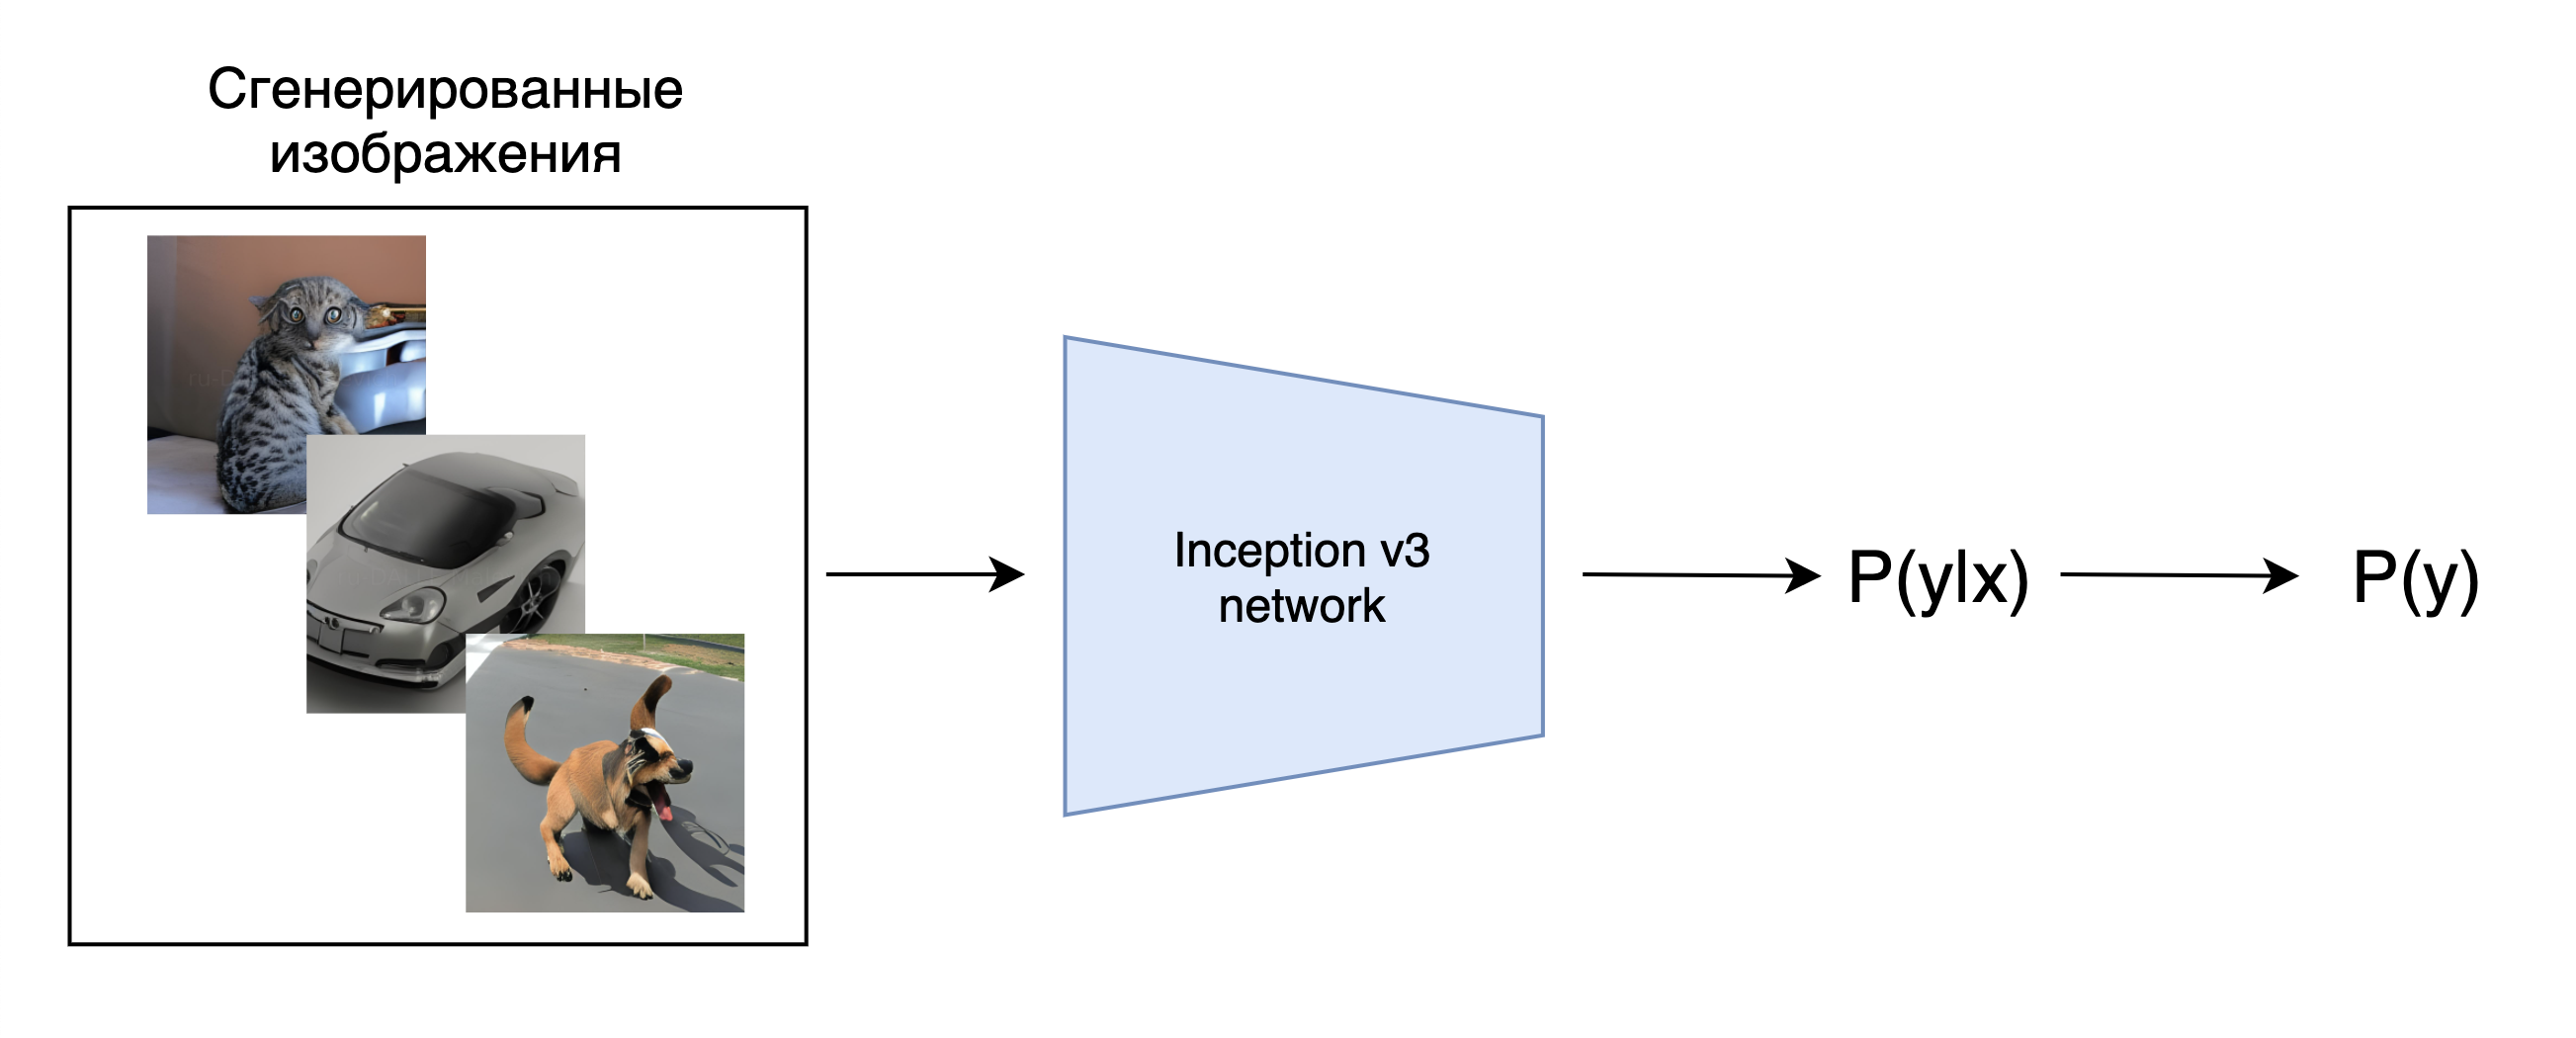

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

FID

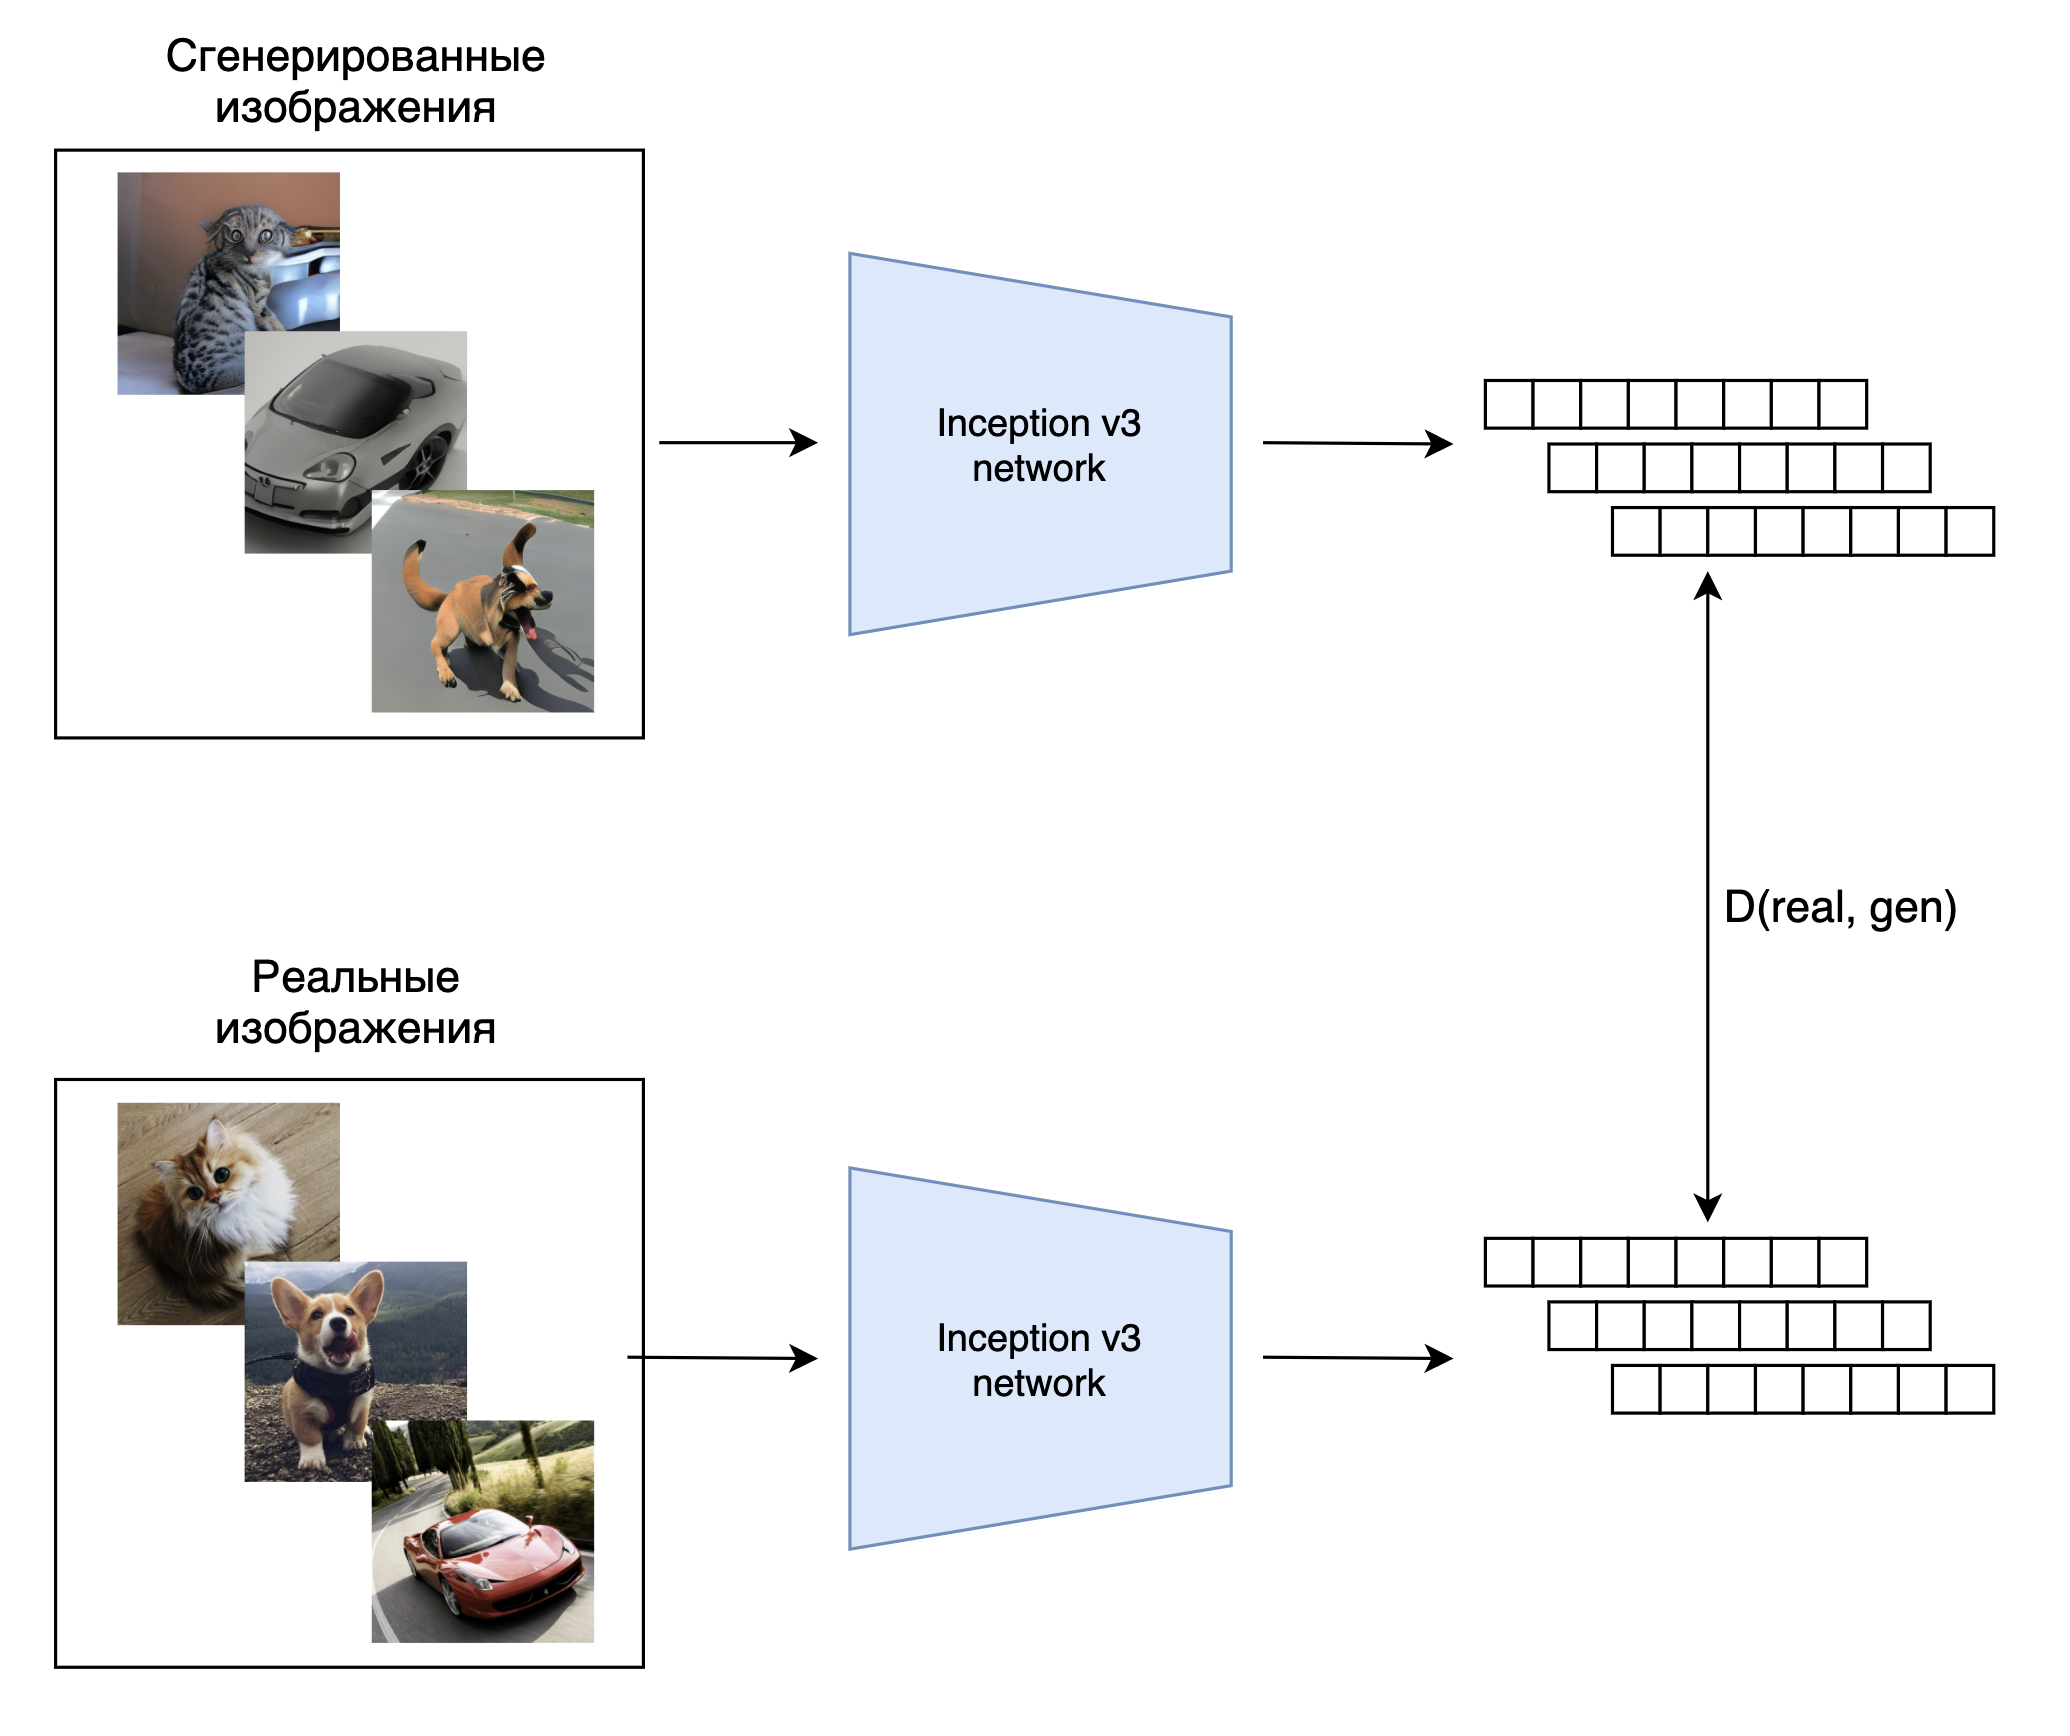

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета.


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет

* Обучить GAN на датасете CIFAR10, используя методы регуляризации: label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей без регуляризаций и с различными их комбинациями (хотя бы одной). Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
DCGAN | |
Label Smoothing (LS) |  |
Spectral Normalization (SN) |  |
DCGAN + LS + SN | |
CIFAR10 | 10.98 ± 0.22 | 3.1508


### Define parameters & Load Dataset

In [38]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline
plt.style.use("ggplot")

class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 8
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images2/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


In [39]:
len(cifar_dataset)

50000

Label:  6


(array([ 140.,  578., 1378., 1406., 1163., 1691., 1246., 1402., 1351.,
         602.,  440.,  344.,  279.,  185.,   83.]),
 array([-0.99215686, -0.86091501, -0.72967321, -0.59843135, -0.46718955,
        -0.33594772, -0.20470588, -0.07346405,  0.05777778,  0.18901961,
         0.32026145,  0.45150328,  0.58274508,  0.71398693,  0.84522873,
         0.97647059]),
 <BarContainer object of 15 artists>)

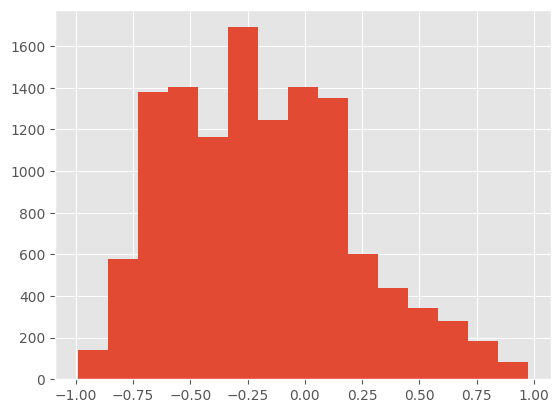

In [7]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

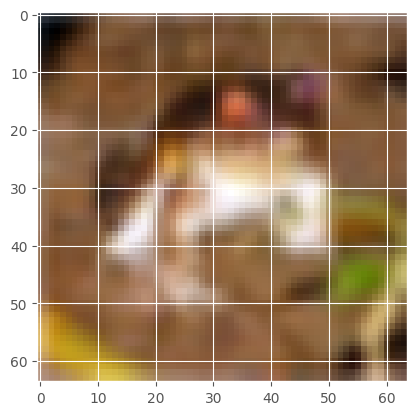

In [8]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    tmp = img.clone()
    for i in range(3):
        tmp[i] = (tmp[i]-tmp[i].min())/(tmp[i].max()-tmp[i].min())
    return tmp

# show  image sample with matplotlib
plt.imshow(np.transpose(denorm(img),(1,2,0)))

In [41]:
# define the dataloader
from torch.utils.data import DataLoader
data_loader = DataLoader(cifar_dataset,
                         batch_size=CFG.batch_size,
                        shuffle=True,
                        num_workers=CFG.workers,
                        drop_last=True)


# Спектральная нормализация

In [10]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

Заместо того, чтобы добавлять шум на входную картинку, будем добавлять шум на каждый слой Дискриминатора (результаты значительно лучше)

In [15]:
class GaussianNoise(nn.Module):                        
    def __init__(self, std=0.1, decay_rate=0.):
        super().__init__()
        self.std = std
        self.decay_rate = decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [16]:
import torch.nn as nn
# Generator
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
          return self.main(input)

# Discriminator

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            GaussianNoise(),
            SpectralNorm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            GaussianNoise(),
            SpectralNorm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.15),
            GaussianNoise(),
            SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.15),
            GaussianNoise(),
            SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.15),
            GaussianNoise(),
            SpectralNorm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )
    def forward(self, input):
          return self.main(input)


In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)
G.apply(weights_init)
# create new Discriminator model
D = Discriminator(CFG.nc, CFG.ndf).to(CFG.device)

In [14]:
# show the output of model
y = G(torch.randn(2, CFG.nz, 1, 1, device=CFG.device))
y.shape

torch.Size([2, 3, 64, 64])

In [19]:
criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(D.parameters(), lr=CFG.lr)
optimizerG = torch.optim.Adam(G.parameters(), lr=(CFG.lr))

Discriminator Training

In [86]:
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample,
#  if it is real, then replace the label with a random number between 0.7 and 1.2, and
#  if it is a fake sample, replace it with 0.0 and 0.3 (for example).
#make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator

In [20]:
LABEL_SMOOTH = 0.9
def train_discriminator(images):
    D.zero_grad()
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(CFG.batch_size).to(CFG.device)*LABEL_SMOOTH
    fake_labels = torch.ones(CFG.batch_size).to(CFG.device)*(1- LABEL_SMOOTH)


    outputs = D(images).view(-1)
    # Loss for real images
    real_score = criterion(outputs, real_labels)
    # Loss for fake images
    z = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = G(z)
    outputs = D(fake_images).view(-1)

    fake_score = criterion(outputs, fake_labels)

    # Sum losses
    d_loss = real_score + fake_score
    # Compute gradients
    real_score.backward()
    fake_score.backward()
    # Adjust the parameters using backprop
    optimizerD.step()
    return d_loss, real_score, fake_score

Generator Training

In [88]:
#Add gauss noise
#noise = 0.005*np.random.uniform()*np.amax(sound)

In [21]:
def train_generator():
    G.zero_grad()
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = np.random.randn(CFG.batch_size, CFG.nz, 1, 1)
#     noise = 0.005*np.random.uniform()*np.amax(z)
#     z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(CFG.device)
    fake_images = G(z)
    labels = torch.ones(CFG.batch_size).to(CFG.device)
    # calculate the generator loss
    outputs = D(fake_images).view(-1)
    g_loss = criterion(outputs, labels)
    # Reset gradients
    # Backprop and optimize
    g_loss.backward()
    optimizerG.step()
    return g_loss, fake_images

## Start the training process

In [22]:
def denorm(img):
    AA = img.clone()
    AA = AA.view(AA.size(0),AA.size(1), -1)
    AA -= AA.min(2, keepdim=True)[0]
    AA /= AA.max(2, keepdim=True)[0]
    AA = AA.view(AA.size(0), 3, 64, 64)
    return AA

In [23]:
def save_fake_images(index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    z = np.random.randn(CFG.batch_size, CFG.nz, 1, 1)
#     noise = 0.005*np.random.uniform()*np.amax(z)
#     z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(CFG.device)
    fake_images = G(z)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [42]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader, 0):
        # Load a batch & transform to vectors
        images = data[0].to(CFG.device)
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)
        # Train the generator
        g_loss, fake_images = train_generator()
        # Inspect the losses
        if (i+1) % 90 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)
    if epoch%10==0:
        torch.save(G, 'DCG')
        torch.save(D, 'DCD')

Epoch [0/300], Step [90/390], d_loss: 0.8126, g_loss: 1.4722, D(x): 0.45, D(G(z)): 0.36
Epoch [0/300], Step [180/390], d_loss: 1.0572, g_loss: 1.7598, D(x): 0.68, D(G(z)): 0.38
Epoch [0/300], Step [270/390], d_loss: 0.9316, g_loss: 1.5656, D(x): 0.35, D(G(z)): 0.58
Epoch [0/300], Step [360/390], d_loss: 0.7586, g_loss: 2.4980, D(x): 0.41, D(G(z)): 0.34
Saving fake_images-0001.png
Epoch [1/300], Step [90/390], d_loss: 0.8198, g_loss: 1.5067, D(x): 0.40, D(G(z)): 0.42
Epoch [1/300], Step [180/390], d_loss: 1.0290, g_loss: 1.6474, D(x): 0.36, D(G(z)): 0.67
Epoch [1/300], Step [270/390], d_loss: 0.8318, g_loss: 2.5217, D(x): 0.48, D(G(z)): 0.35
Epoch [1/300], Step [360/390], d_loss: 1.0290, g_loss: 1.0696, D(x): 0.35, D(G(z)): 0.68
Saving fake_images-0002.png
Epoch [2/300], Step [90/390], d_loss: 1.3775, g_loss: 1.2001, D(x): 0.35, D(G(z)): 1.03
Epoch [2/300], Step [180/390], d_loss: 0.7954, g_loss: 1.4548, D(x): 0.44, D(G(z)): 0.36
Epoch [2/300], Step [270/390], d_loss: 0.9207, g_loss: 1.

Epoch [21/300], Step [270/390], d_loss: 0.9280, g_loss: 2.0502, D(x): 0.49, D(G(z)): 0.44
Epoch [21/300], Step [360/390], d_loss: 0.8844, g_loss: 1.7242, D(x): 0.35, D(G(z)): 0.53
Saving fake_images-0022.png
Epoch [22/300], Step [90/390], d_loss: 0.8220, g_loss: 1.1706, D(x): 0.46, D(G(z)): 0.36
Epoch [22/300], Step [180/390], d_loss: 0.8471, g_loss: 1.9612, D(x): 0.49, D(G(z)): 0.36
Epoch [22/300], Step [270/390], d_loss: 0.9271, g_loss: 1.3538, D(x): 0.54, D(G(z)): 0.39
Epoch [22/300], Step [360/390], d_loss: 0.8263, g_loss: 1.9035, D(x): 0.47, D(G(z)): 0.35
Saving fake_images-0023.png
Epoch [23/300], Step [90/390], d_loss: 0.7708, g_loss: 1.9428, D(x): 0.39, D(G(z)): 0.38
Epoch [23/300], Step [180/390], d_loss: 0.8165, g_loss: 2.1113, D(x): 0.46, D(G(z)): 0.36
Epoch [23/300], Step [270/390], d_loss: 0.8819, g_loss: 1.6616, D(x): 0.35, D(G(z)): 0.53
Epoch [23/300], Step [360/390], d_loss: 0.7513, g_loss: 1.3238, D(x): 0.37, D(G(z)): 0.38
Saving fake_images-0024.png
Epoch [24/300], St

KeyboardInterrupt: 

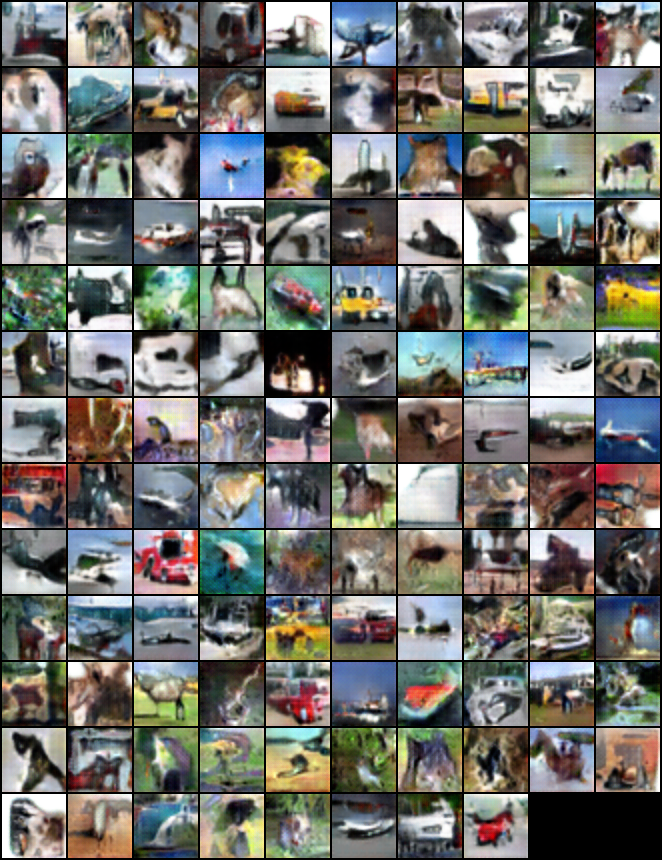

In [21]:
Image(os.path.join(CFG.sample_dir, 'fake_images-0038.png'))

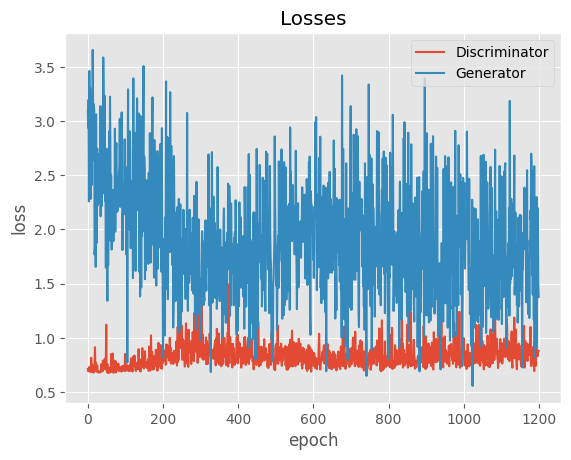

In [29]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

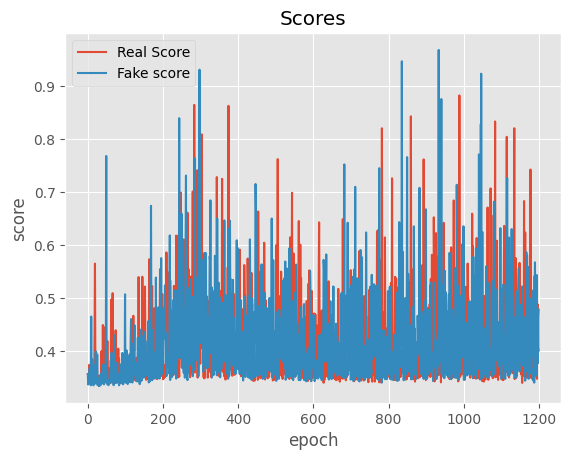

In [30]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [31]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

"git" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
from torch.utils.data import Dataset
# import function from pytorch_gan_metrics
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim

    def __len__(self):
        return 500

    def __getitem__(self, index):
        return self.G(torch.randn(1, self.z_dim, 1, 1).cuda())[0]

# define dataset
dataset = GeneratorDataset(G, CFG.nz)
#create dataloader
data_loader = DataLoader(dataset,
                         batch_size=CFG.batch_size,
                        shuffle=True)



In [35]:
# Inception Score
IS = get_inception_score(data_loader)
# Frechet Inception Distance
FID = get_fid(data_loader, 'cifar10.train.npz')
# Inception Score + Frechet Inception Distance
(IS, IS_std), FID = get_inception_score_and_fid(
    images, 'cifar10.train.npz')

In [37]:
print(IS)
print(FID)
print(IS, IS_std, FID)

7.417332570076143
4.06522724852914
7.417332570076143 0.23494796572012222 4.06522724852914
